# LSTM model

The notebook is organized into the following sections:

1. **Model overview - Encoder-Decoder LSTM for multi-horizon forecasting with exogenous inputs**:
   Motivation and architecture.

2. **Preliminaries**:
   Data loading, module imports, seeding, and device setup.

3. **Pipeline**:
   Walkthrough of the LSTM training/evaluation pipeline.

4. **Hyperparameter tuning (Optuna)**:
   Start a new study or load and inspect an existing one.

5. **Tuning results**:
   Procedure details and outcome analysis.

6. **Testing**:
   Generate final predictions on the test period using the tuned model.


## Model overview - Encoder-Decoder LSTM for multi-horizon forecasting with exogenous inputs

We use an **Encoder–Decoder LSTM** architecture. The LSTM encoder processes a historical sequence made of **endogenous** variables (the target and its lags) and **exogenous** variables (weather factors and their lags, as well as time features), compressing them into a latent state $(h, c)$. The LSTM decoder, initialized with this state, produces high-dimensional representations of future predictions by combining covariates known in the future and, if enabled, an **autoregressive signal** based on past or predicted target values. Finally, these intermediate representations yield the forecasts after passing through a linear or MLP head (the same head, with shared weights, is applied at every decoder timestamp). The unrolled architecture is shown in the figure below (in the simplified case of a single hidden layer with an autoregressive signal).

Originally proposed for machine translation ([Sutskever et al., 2014](https://d-nb.info/1195237189/34)), the seq2seq architecture fits time-series forecasting well: it supports mismatched input/output lengths, integrates exogenous variables known in the future, and can autoregressively use previous predictions to construct a coherent forecast trajectory ([Wilms et al., 2018](https://arxiv.org/pdf/1907.09207)).

### Inputs and autoregressive variants

The encoder/decoder inputs are configured via `heat_forecast.pipeline.lstm.FeatureConfig`.

* **Encoder:** receives the historical sequence composed of **past endogenous variables** (`endog_past`, which always includes the target and optionally its seasonal lags or moving averages) and **past exogenous variables** (`exog_past`, including weather and time features, and optionally other features derived from them).
* **Decoder:** receives **future endogenous variables known in advance** (e.g., daily or weekly lags, usable only if the lag is not shorter than the forecast horizon to avoid leakage), **future exogenous variables known in advance** (we assume weather forecasts are available), and optionally an additional term `y_prev` that enables different autoregressive modes controlled by `use_ar`.

Supported modes:

1. `use_ar="none"`
   Predictions depend only on future covariates (which may still include target lags).

2. `use_ar="prev"`
   The decoder receives, at each step, the previous target value. For the first step it uses the last observed value; for subsequent steps it uses the predicted value (or the true value, but only during training with teacher forcing). The sequence is generated one step at a time.

3. `use_ar="24h"`
   The decoder receives blocks of 24 consecutive target values. Initially it uses the last 24 observed values; afterwards these are replaced with the predicted ones (or the true ones during training with teacher forcing). This mode is useful only for horizons longer than 24 hours; otherwise it effectively reduces to including the daily target lag in the decoder without needing autoregression.

These modes balance simplicity and expressiveness: without autoregression training is faster and more stable, while with autoregression the model can better exploit dependencies of the target on its recent history within the forecast horizon.

Feature configuration (`endog_past`, `exog_past`, `endog_fut`, `exog_fut`) is flexible. It can include:

* the target and weather exogenous variables;
* their lags or moving averages;
* a binary variable derived from temperature (warm/cold season);
* time features (hour of day, day of week, holidays, month of year).

In principle, a sufficiently powerful model could reconstruct lags and moving averages of the target and exogenous variables on its own, provided the encoder window is long enough. In practice, supplying them explicitly often helps surface key information such as seasonality and trend, as also shown in the literature ([Claveria et al., 2017](https://www.scopus.com/pages/publications/84946431092); [Zhang et al., 2005](https://www.sciencedirect.com/science/article/pii/S0377221703005484)), where signal decomposition into seasonal and trend components improved performance. In our case, lags and moving averages play a similar role: they help the model recognize recurring patterns and long-term variations without explicit decompositions.

We avoided explicit signal decomposition mainly for computational reasons. A decomposition would have to be recomputed for every encoder window (it cannot be done once on the whole dataset without causing leakage). Even more critically, with an autoregressive decoder one would need to compute the decomposition of the target (or of its predictions) at every autoregressive step. This is impractical: our series often exhibit both daily and weekly seasonality, which would require sophisticated methods (e.g., MSTL) to estimate the two components separately, at high cost.

That said, we do not rule out that model variants integrating explicit decompositions (e.g., only in the encoder if using autoregression in the decoder), in **MSTL-LSTM** style, could yield further improvements and are a promising direction for future work.

## Preliminaries

Environment and paths initialization:

In [3]:
# --- Detect if running on Google Colab & Set base dir ---
# %cd /home/giovanni.lombardi/heat-forecast/notebooks
import subprocess
from pathlib import Path
import sys

def in_colab() -> bool:
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

# Install required packages only if not already installed
def pip_install(pkg: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Set base directory and handle environment
if in_colab():
    # Make sure IPython is modern (avoids the old %autoreload/imp issue if you ever use it)
    pip_install("ipython>=8.25")
    pip_install("ipykernel>=6.29")
    
    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    for pkg in ["statsmodels", "statsforecast", "mlforecast"]:
        pip_install(pkg)

    # Mount Google Drive
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')

    # Set base directory to your Drive project folder
    BASE_DIR = Path('/content/drive/MyDrive/heat-forecast')

    # Add `src/` to sys.path for custom package imports
    SRC_PATH = BASE_DIR / 'src'
    if str(SRC_PATH) not in sys.path:
        sys.path.append(str(SRC_PATH))

    # Sanity checks (helpful error messages if path is wrong)
    assert SRC_PATH.exists(), f"Expected '{SRC_PATH}' to exist. Fix BASE_DIR."
    pkg_dir = SRC_PATH / "heat_forecast"
    assert pkg_dir.exists(), f"Expected '{pkg_dir}' package directory."
    init_file = pkg_dir / "__init__.py"
    assert init_file.exists(), f"Missing '{init_file}'. Add it so Python treats this as a package."

else:
    # Local: either rely on editable install (pip install -e .) or add src/ when running from repo
    # Assume notebook lives in PROJECT_ROOT/notebooks/
    BASE_DIR = Path.cwd().resolve().parent
    SRC_PATH = BASE_DIR / "src"

    added_src = False
    if (SRC_PATH / "heat_forecast").exists() and str(SRC_PATH) not in sys.path:
        sys.path.append(str(SRC_PATH))
        added_src = True

# --- Logging setup ---
import logging
from zoneinfo import ZoneInfo
from datetime import datetime

LOG_DIR  = (BASE_DIR / "logs")
LOG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE = LOG_DIR / "run.log"
PREV_LOG = LOG_DIR / "run.prev.log"

# If there's a previous run.log with content, archive it to run.prev.log
if LOG_FILE.exists() and LOG_FILE.stat().st_size > 0:
    try:
        # Replace old run.prev.log if present
        if PREV_LOG.exists():
            PREV_LOG.unlink()
        LOG_FILE.rename(PREV_LOG)
    except Exception as e:
        # Fall back to truncating if rename fails (e.g., file locked)
        print(f"[warn] Could not archive previous log: {e}. Truncating current run.log.")
        LOG_FILE.write_text("")

# Configure logging: fresh file for this run + echo to notebook/stdout
file_handler   = logging.FileHandler(LOG_FILE, mode="w", encoding="utf-8")
stream_handler = logging.StreamHandler(sys.stdout)

fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(name)s | %(message)s",
                        datefmt="%m-%d %H:%M:%S")
file_handler.setFormatter(fmt)
stream_handler.setFormatter(fmt)

root = logging.getLogger()
root.handlers[:] = [file_handler, stream_handler]  # replace handlers (important in notebooks)
root.setLevel(logging.INFO)

# Use Rome time
logging.Formatter.converter = lambda *args: datetime.now(ZoneInfo("Europe/Rome")).timetuple()

logging.captureWarnings(True)
logging.info("=== Logging started (fresh current run) ===")
logging.info("Previous run (if any): %s", PREV_LOG if PREV_LOG.exists() else "none")

if added_src:
    logging.info("heat_forecast not installed; added src/ to sys.path")
else:
    logging.info("heat_forecast imported without modifying sys.path (likely installed)")

OPTUNA_DIR = BASE_DIR / "results" / "finetuning" / "lstm"
OPTUNA_DIR.mkdir(parents=True, exist_ok=True)
logging.info("BASE_DIR (make sure it's '*/heat-forecast/', else cd and re-run): %s", BASE_DIR)
logging.info("LOG_DIR: %s", LOG_DIR)
logging.info("OPTUNA_DIR: %s", OPTUNA_DIR)

[warn] Could not archive previous log: [WinError 32] Impossibile accedere al file. Il file è utilizzato da un altro processo: 'C:\\Users\\giolo\\OneDrive\\DocumentiOneDrive\\Phython scripts\\Tirocinio Optit\\heat-forecast\\logs\\run.log' -> 'C:\\Users\\giolo\\OneDrive\\DocumentiOneDrive\\Phython scripts\\Tirocinio Optit\\heat-forecast\\logs\\run.prev.log'. Truncating current run.log.
10-04 15:03:39 | INFO | root | === Logging started (fresh current run) ===
10-04 15:03:39 | INFO | root | Previous run (if any): none
10-04 15:03:39 | INFO | root | heat_forecast imported without modifying sys.path (likely installed)
10-04 15:03:39 | INFO | root | BASE_DIR (make sure it's '*/heat-forecast/', else cd and re-run): C:\Users\giolo\OneDrive\DocumentiOneDrive\Phython scripts\Tirocinio Optit\heat-forecast
10-04 15:03:39 | INFO | root | LOG_DIR: C:\Users\giolo\OneDrive\DocumentiOneDrive\Phython scripts\Tirocinio Optit\heat-forecast\logs
10-04 15:03:39 | INFO | root | OPTUNA_DIR: C:\Users\giolo\One

Ensure [compatibility with Numba](https://numba.readthedocs.io/en/stable/user/installing.html#numba-support-info).

In [68]:
import sys, numpy, numba
logging.info("=== Current Environment ===")
logging.info("Python : %s", sys.version.split()[0])
logging.info("NumPy  : %s", numpy.__version__)
logging.info("Numba  : %s", numba.__version__)

10-03 22:45:16 | INFO | root | === Current Environment ===
10-03 22:45:16 | INFO | root | Python : 3.12.9
10-03 22:45:16 | INFO | root | NumPy  : 2.2.6
10-03 22:45:16 | INFO | root | Numba  : 0.61.2


Import modules:

In [69]:
# --- Magic Commands ---
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import os
os.environ["OPTUNA_LOGGING_DISABLE_DEFAULT_HANDLER"] = "1" # prevent Optuna from attaching its handler
import stat
import logging
from datetime import datetime
from itertools import product
import torch
import optuna
import copy

# --- Third-Party Libraries ---
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Plotting Configuration ---
interactive = False  # Set to False for static plots
plt.style.use("seaborn-v0_8")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'both'

# --- YAML Customization ---
def _tuple_representer(dumper, data):
    return dumper.represent_sequence(
        yaml.resolver.BaseResolver.DEFAULT_SEQUENCE_TAG,
        list(data)
    )
yaml.SafeDumper.add_representer(tuple, _tuple_representer)

# --- Safe File Deletion Helper ---
def _on_rm_error(func, path, exc_info):
    os.chmod(path, stat.S_IWRITE)
    func(path)

# --- Project-Specific Imports ---
from heat_forecast.utils.cv_utils import get_cv_params_for_test
from heat_forecast.pipeline.lstm import (
    NormalizeConfig, ModelConfig, DataConfig, FeatureConfig, TrainConfig, 
    LSTMRunConfig, LSTMPipeline
)
from heat_forecast.utils.optuna import (
    OptunaStudyConfig, run_study, continue_study, describe_suggester, rename_study, create_substudy_by_param
)

from heat_forecast.utils.fileshandling import remove_tree

logging.info("All imports successful.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
10-03 22:45:18 | INFO | root | All imports successful.


Import pre-elaborated data.

In [70]:
heat_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'heat.csv'
aux_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'auxiliary.csv'
heat_df = pd.read_csv(heat_path, parse_dates=['ds'])
aux_df = pd.read_csv(aux_path, parse_dates=['ds'])
logging.info("Loaded heat data: %s", heat_path.relative_to(BASE_DIR))
logging.info("Loaded auxiliary data: %s", aux_path.relative_to(BASE_DIR))

10-03 22:45:25 | INFO | root | Loaded heat data: data\timeseries_preprocessed\heat.csv
10-03 22:45:25 | INFO | root | Loaded auxiliary data: data\timeseries_preprocessed\auxiliary.csv


Set device:

In [71]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {DEVICE}")

10-03 22:45:26 | INFO | root | Using device: cpu


Set a seed (set to None to skip):

In [72]:
SEED = 42
logging.info(f"Using seed: {SEED}")

10-03 22:45:29 | INFO | root | Using seed: 42


## Model Pipeline

### Operational Summary

The pipeline operationalizes the Encoder–Decoder LSTM model and provides an end-to-end workflow that includes:

1. **Feature engineering**: builds lags, moving averages, time-based covariates, binary seasonal flags, and integrates exogenous variables.
2. **Dataset preparation**: constructs sliding windows for encoder and decoder, applying normalization if configured.
3. **Training**: manages teacher forcing, early stopping, learning rate scheduling, gradient clipping, and optimizer settings.
4. **Evaluation & forecasting**: produces predictions in the original scale (including inverse transformation if differences are used) and supports **rolling cross-validation**.

#### Configuration Reference

The pipeline configuration is set throughout the following dataclasses.

**`NormalizeConfig`** 

Controls how target and features are normalized. Arguments:
* **`mode`** (`"none" | "global" | "per_sample"`, default: `"global"`):

  * `"none"` → no normalization applied.
  * `"global"` → normalize using mean/std computed once on the training set.
  * `"per_sample"` → normalize each encoder window separately.
* **`eps`** *(float, default=1e-6)*: small constant to avoid division by zero when scaling.
* **`std_ddof`** *(int, default=0)*: degrees of freedom in standard deviation (0 = population, 1 = sample).
* **`exog_skip_cols`** *(tuple[str])*: exogenous columns to exclude from normalization (e.g., cyclic encodings such as sin/cos).
* **`endog_skip_cols`** *(tuple[str])*: endogenous columns to exclude from normalization.

**`ModelConfig`** 

Defines the LSTM network architecture. Arguments:
* **`input_len`** *(int, default=168)*: encoder context length (number of past time steps fed to the encoder).
* **`output_len`** *(int, default=24)*: forecast horizon length (number of future steps predicted by the decoder).
* **`hidden_size`** *(int, default=64)*: dimensionality of LSTM hidden states.
* **`num_layers`** *(int, default=1)*: number of stacked LSTM layers for encoder/decoder.
* **`head`** (`"linear" | "mlp"`, default=`"linear"`): output projection type applied at each decoder step.
* **`dropout`** *(float, default=0.0)*: dropout probability between LSTM layers.
* **`use_ar`** (`"none" | "prev" | "24h"`, default=`"prev"`): autoregression mode in the decoder:

  * `"none"` → decoder uses only covariates (no autoregression).
  * `"prev"` → decoder input includes the last observed/predicted target at each step.
  * `"24h"` → decoder input includes a sliding block of the last 24 targets.

**`DataConfig`** 

Controls dataset creation and batching. Arguments:
* **`stride`** *(int, default=1)*: step size between consecutive sliding windows (1 = hourly, 24 = daily).
* **`gap_hours`** *(int, default=0)*: gap in hours between the training set end and validation set start, used to avoid leakage.
* **`batch_size`** *(int, default=64)*: batch size for training and evaluation.
* **`num_workers`** *(int, default=0)*: number of DataLoader workers (parallelism in data loading).
* **`shuffle_train`** *(bool, default=True)*: whether to shuffle training batches.
* **`pin_memory`** *(Optional[bool], default=None)*: if True, enables pinned memory (usually beneficial when using CUDA).

**`FeatureConfig`** 

Determines which features are engineered and included. Arguments:
* **`exog_vars`** *(tuple[str], default=("temperature",))*: exogenous variables taken from auxiliary data (allowed: temperature, dew_point, wind_speed, pressure, humidity).
* **`hour_averages`** *(tuple[int])*: moving average windows in hours (e.g., `(24, 168)`).
* **`endog_hour_lags`** *(tuple[int], default=(24, 168))*: endogenous lags in hours (also applies to exogenous if `include_exog_lags=True`).
* **`include_exog_lags`** *(bool, default=False)*: whether to compute lags for exogenous variables as well.
* **`use_differences`** *(bool, default=False)*: if True, the target is modeled as 24-hour differences (requires `input_len ≥ 24`). Adds a column `y_diff`.
* **`time_vars`** *(tuple[str], default=("hod","dow","moy","wss"))*: cyclical time encodings:

  * `hod`: hour of day (sin/cos).
  * `dow`: day of week (sin/cos).
  * `moy`: month of year (sin/cos).
  * `wss`: working vs. weekend/holiday flag.
* **`use_cold_season`** *(bool, default=False)*: add binary flag for “cold season”.
* **`cold_temp_threshold`** *(Optional[float], default=15.0)*: if set, defines cold season based on a temperature moving average; otherwise fixed months (NDJFM).
* **`cold_avg_hours`** *(int, default=96)*: moving average window length for the cold-season rule.

**`TrainConfig`** 

Defines the training process and optimization. Arguments:
* **`learning_rate`** *(float, default=1e-3)*: initial learning rate.
* **`n_epochs`** *(int, default=20)*: maximum number of training epochs.
* **`patience`** *(int, default=5)*: early stopping patience (number of epochs without improvement tolerated).
* **`es_rel_delta`** *(float, default=0.0)*: minimum relative improvement required to reset early stopping.
* **`tf_mode`** (`"linear" | "step"`, default=`"linear"`): schedule type for teacher forcing probability decay.
* **`tf_drop_epochs`** *(int, default=15)*: number of epochs over which teacher forcing probability decays to zero.
* **`use_lr_drop`** *(bool, default=True)*: whether to reduce learning rate once teacher forcing reaches zero (or at a fixed epoch).
* **`lr_drop_at_epoch`** *(Optional[int], default=None)*: epoch at which to drop LR (if None, drop occurs when TF ends).
* **`lr_drop_factor`** *(float, default=0.5)*: multiplicative factor for LR reduction.
* **`grad_clip_max_norm`** *(float, default=10.0)*: maximum gradient norm for gradient clipping.
* **`weight_decay`** *(float, default=0.0)*: L2 weight regularization.
* **`max_walltime_sec`** *(Optional[float], default=None)*: maximum wall-clock training time (can be used for pruning/stopping).

**`LSTMRunConfig`** 

Bundles all configuration classes into a single object. Arguments:
* **`model`**: instance of `ModelConfig`.
* **`data`**: instance of `DataConfig`.
* **`features`**: instance of `FeatureConfig`.
* **`train`**: instance of `TrainConfig`.
* **`norm`**: instance of `NormalizeConfig`.
* **`seed`** *(Optional[int])*: random seed for reproducibility (affects data shuffling, teacher forcing randomness, etc.).


### Example of usage of the pipeline

Example configuration:

In [31]:
# Choose unique_id and filter
unique_id = 'F1'
heat_id_df = heat_df[heat_df['unique_id'] == unique_id]
aux_id_df = aux_df[aux_df['unique_id'] == unique_id]


# Set configuration of the pipeline
config = LSTMRunConfig(
    model=ModelConfig(
        input_len=72, 
        output_len=168, 
        hidden_size=64, 
        num_layers=2,
        head="linear",
        dropout=0.0,
        use_ar="24h"
    ),
    data=DataConfig(
        batch_size=64,   
    ),
    features=FeatureConfig(
        exog_vars=("temperature",),
        hour_averages=(),        
        endog_hour_lags=(24, 168,),  
        use_differences=False,
        use_cold_season=False,
        cold_temp_threshold=15,
        include_exog_lags=False
    ),
    train=TrainConfig(
        learning_rate=1e-3, 
        n_epochs=20, 
        patience=5, 
        tf_drop_epochs=7,
        tf_mode="linear",
        weight_decay=1e-5
    ),
    norm=NormalizeConfig(mode="global"),
    seed=SEED,
)

# Build the pipeline
pipe = LSTMPipeline(target_df=heat_id_df, config=config, aux_df=aux_id_df)

10-03 18:47:24 | INFO | pipeline.lstm | [pipe init] setting random seed: 42


Generate loaders:

In [34]:
# Choose params for data split
end_train = pd.Timestamp("2023-11-01 23:00")
end_val   = pd.Timestamp("2024-04-01 23:00")  # val will start at end_train + 1h automatically

# Build datasets and load
train_loader, val_loader = pipe.make_loaders(
    end_train=end_train,
    end_val=end_val,
)

10-03 18:48:47 | INFO | pipeline.lstm | [loaders] loaders built: used stride=1, bs=64, gap=0h, norm=global (inferred from train), shuffle_train=True


Description of the prepared dataset:

In [35]:
report_data = pipe.describe_dataset()

10-03 18:48:57 | INFO | pipeline.lstm | [dataset]
Rows:                  51455
Date range:            2019-07-08 00:00:00 → 2025-05-20 22:00:00
Train range:           2019-07-08 00:00:00 → 2023-11-01 23:00:00
Val range:             2023-11-02 00:00:00 → 2024-04-01 23:00:00
Frequency:             h
Target:                y
Uses differences:      False
Endog/Exog counts:     3 / 9
Endog columns:         y, y_lag24, y_lag168
Exog columns:          temperature, hour_sin, hour_cos, dow_sin, dow_cos, month_sin, month_cos, wss_sin, wss_cos
Time features:         8 | hour_sin, hour_cos, dow_sin, dow_cos, month_sin, month_cos, wss_sin, wss_cos
Climate features:      1 | temperature
Decoder safe endog:    1 | y_lag168
Decoder blocked endog: 2 | y, y_lag24
Normalization:         global (endog=3, exog=1)
Model I/O:             T_in=72, T_out=168 | enc_in=12, dec_in=11
Configured features:   exog_vars=temperature | hour_averages=— | endog_hour_lags=24, 168 (include_exog_lags=False)
Device:         

Description of the prepared model:

In [36]:
report_model = pipe.describe_model()

10-03 18:49:05 | INFO | pipeline.lstm | [model]
Architecture:          EncDecLSTM
Device:                cpu
Seq lengths:           T_in=72, T_out=168
Encoder input size:    12 (endog(3) + exog(9))
Decoder input size:    11 (prev_pred(1) + safe_endog(1) + exog(9))
Endog/Exog counts:     3 / 9
Decoder safe endog:    1 | y_lag168
Decoder blocked endog: 2 | y, y_lag24
Hidden size:           64
Layers:                2
Dropout:               0.0
Dropout locations:     none
Head:                  linear
Params (estimated):    enc=53,248 | dec=52,992 | head=65 | total=106,305
Params (exact):        enc=53,248 | dec=52,992 | head=65 | total=106,305


The floowing method `sanity_overfit_one_batch` performs a **sanity check** by trying to overfit the model on a tiny, fixed subset of the training data. It trains for up to `max_epochs` without early stopping, then checks whether the training loss drops by at least a required relative amount (`tol_rel_drop`).

If successful, it signals the pipeline and optimization are working correctly; otherwise, it may indicate bugs or misconfigurations.

In [37]:
check = pipe.sanity_overfit_one_batch(
    train_loader,
    max_epochs=300,         # bump if needed
    tol_rel_drop=0.8,    # percentage drop in ORIGINAL units (MAE by default) to consider as "passed"
    restore_weights=True,   # keep your model “fresh” after the check
    n_samples=16,           # tiny fixed subset
    gen_seed=SEED           # deterministic subset selection
)

10-03 18:49:09 | INFO | pipeline.lstm | [sanity] Overfitting one batch (bs=16, epochs=300, tol_rel_drop=0.8) idxs[:8]=[14957, 948, 22330, 24737, 24709, 5852, 15208, 30177]
10-03 18:49:09 | INFO | pipeline.lstm | [model] EncDecLSTM(hidden=64, n_layers=2, head=linear, dropout=0.0, in_enc=12, in_dec=11, use_ar=24h, n_learnable_params=106305)
10-03 18:49:09 | INFO | pipeline.lstm | [train] starting training without validation and without early stopping...
10-03 18:49:09 | INFO | pipeline.lstm |   Train params: epochs=300, lr=0.001, patience=0, es_rel_delta=0.0, tf_mode='linear', tf_ep='7', use_lr_drop=True, lr_ep=None, lr_drop_factor=0.5, es_start_epoch=1, max_grad_norm=1.0, weight_decay=1e-05
10-03 18:49:09 | INFO | pipeline.lstm |   Data params: norm_mode=global.
10-03 18:49:09 | INFO | pipeline.lstm | [wd] parameter groups for optimizer:
10-03 18:49:09 | INFO | pipeline.lstm |   Decay (9 params): ['encoder.weight_ih_l0', 'encoder.weight_hh_l0', 'encoder.weight_ih_l1', 'encoder.weight_hh

This method trains the model under the current configuration.
If a validation loader is provided, it monitors validation loss, applies early stopping, and logs the best epoch reached; otherwise, it trains for the full number of epochs and reports final training loss.
In all cases, it applies the configured learning schedule (teacher forcing, LR drop, gradient clipping), records history and metrics, and returns a results dictionary with training outcomes.

In [ ]:
pipe.fit(train_loader, val_loader)

The `predict` method produces forecasts on the original target scale. It can run in two modes:

* Batch mode: pass a `val_loader` to predict multiple windows, returning `unique_id`, `ds`, `cutoff`, and predictions.
* Single-horizon mode: pass a `cutoff` to predict one forecast horizon, returning `unique_id`, `ds`, and predictions.

We use the first mode to compute predictions over several months.

In [30]:
# Ensure this holds: start_test >= end_train + gap + 1h, else will raise
start_test = pd.Timestamp("2024-09-01 00:00:00")
end_test   = pd.Timestamp("2024-12-01 23:00:00")
gap        = int(pipe.config.data.gap_hours) # default is 0

# When norm.mode="global", statistics are computed from the training slice. 
# If no training range is provided, the pipeline will reuse cached stats (if available). 
# To avoid surprises, it is recommended to always specify the train dates explicitly.
_, test_loader = pipe.make_loaders(
    end_train=end_train,
    start_val=start_test,
    end_val=end_test,
)

# Copute predictions on the given loader
preds = pipe.predict(val_loader=test_loader, alias="LSTM")
display(preds.head())

10-03 18:47:12 | INFO | heat_forecast.pipeline.lstm | [loaders] loaders built using stride=1, bs=64, gap=0h, norm=global (inferred from train), shuffle_train=True


,unique_id,ds,cutoff,LSTM
0,F1,2024-09-01 00:00:00,2024-08-31 23:00:00,23.457
1,F1,2024-09-01 01:00:00,2024-08-31 23:00:00,21.011
2,F1,2024-09-01 02:00:00,2024-08-31 23:00:00,20.571
3,F1,2024-09-01 03:00:00,2024-08-31 23:00:00,21.492
4,F1,2024-09-01 04:00:00,2024-08-31 23:00:00,23.333


In [40]:
from heat_forecast.utils.plotting import interactive_plot_cutoff_results

interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=preds,
    aux_df=aux_df,
    n_windows=1,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 9),
)

interactive(children=(IntSlider(value=42, continuous_update=False, description='Cutoff idx:', max=84), Output(…

## Optuna tuning

We tune the model using **Optuna**, a Python framework for hyperparameter optimization that supports both **grid search** and more efficient, adaptive methods. With Optuna we can easily run evaluations over a fixed hyperparameter grid, or use its **TPE (Tree-structured Parzen Estimator)** sampler to explore continuous, large and / or conditional search spaces in a data-driven way. The TPE sampler fits separate probabilistic models to "good" and "bad" parameter sets and selects new trials that maximize the ratio of the two (i.e. promising configurations).

For more detail on TPE and Optuna, see:

* [Optuna main site](https://optuna.org/)
* [TPESampler documentation](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html) 
* [This article, for a deeper understanding of the TPESampler](https://arxiv.org/abs/2304.11127)

Overview of the following subsections:
* **"Start a new study"**: how to create and run a new optimization study from scratch.
* **"Review past studies"**: how to load a completed study to delete, copy, or continue it, as well as inspect results in detail.

A detailed review and commentary of the tuning results is provided in the next section.

### Start a new study

As a first step to start a study, select the time series (`unique_id`) you want to optimize. Next, choose a **suggester function** (or define a new one in `heat_forecast/suggesters/lstm.py`) that specifies the hyperparameter search space. Finally, configure the **Optuna study** by setting options such as sampler, pruner, study name, and other parameters controlling the optimization process. 

In [41]:
# --- Step 1: Select series ---
unique_id = 'F1'

# Set path based on unique_id
db_path = OPTUNA_DIR / f"optuna_{unique_id}.db"  # single DB file for each id
storage_url = f"sqlite:///{db_path.as_posix()}"

# --- Step 2: Define search space ---
suggester_name = "final_v3_F1"
desc = describe_suggester(suggester_name)
logging.info(f"Suggester used:\n{desc}")

# --- Step 3: Configure study ---
optuna_cfg = OptunaStudyConfig(
    # General
    study_name='final_study_v3_F1',
    n_trials=None,           # number of trials, use None for grid search
    timeout=None,            # timeout for the study (max time per trial in seconds)
    seed=SEED,               # seed for reproducibility of the optuna sampler
    storage=storage_url,     # storage URL for the study 
    pruner="nop",            # type of pruner: "percentile", "median", "nop"
    sampler="grid",          # type of sampler: "tpe", "grid"
)

10-03 19:22:06 | INFO | root | Suggester used:
### final_v3_F1

LSTM final sugg v3 (final 3 candidate configurations with repeats).

**Parameters:**
- `config` (categorical): {'best_anb', 'candidate_1', 'candidate_2'}
- `repeat_idx` (categorical): {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

**Notes / constraints:**
- `repeat_idx` repeats each config 10×.
- Configuration 'best_anb' achieved the best `avg_near_best` (trial #34).
- Other configurations are candidates derived from the tuning analysis.
- `es_rel_delta` is set to 0.0 to milden early stopping.


Run the study:

In [11]:
do_run = False

if do_run:
    # Set path based on unique_id
    db_path = OPTUNA_DIR / f"optuna_{unique_id}.db"  # single DB file for each id
    storage_url = f"sqlite:///{db_path.as_posix()}"

    # Set base configuration of the pipeline
    base_cfg = LSTMRunConfig(
        model=ModelConfig(),
        data=DataConfig(),
        features=FeatureConfig(),
        train=TrainConfig(),
        norm=NormalizeConfig(),
    )

    start_train = None # -> first date available 
    start_val = pd.Timestamp("2023-11-01 00:00") 
    end_train = pd.Timestamp("2023-10-31 23:00")  
    end_val = pd.Timestamp("2024-04-01 23:00")

    optuna_cfg.storage = storage_url

    study = run_study(
        unique_id,
        heat_df, 
        aux_df, 
        base_cfg,
        start_train=start_train, end_train=end_train, 
        start_val=start_val, end_val=end_val,
        optuna_cfg=optuna_cfg,
        suggest_config_name=suggester_name,
    )
    print("Best value (val loss):", study.best_value)
    print("Best params:", study.best_trial.params)

### Review past studies

#### Load and/or modify a study

See available studies for a fixed ID:

In [73]:
# Choose unique_id
unique_id = 'F1'

# Set path based on unique_id
db_path = OPTUNA_DIR / f"optuna_{unique_id}.db"  # single DB file for each id
storage_url = f"sqlite:///{db_path.as_posix()}"

# Get all study summaries
study_summaries = optuna.study.get_all_study_summaries(storage=storage_url)

# Print study summaries
study_summaries = sorted(study_summaries, key=lambda s: s.study_name)
lines = [f"Study name: {s.study_name}, trials: {s.n_trials}" for s in study_summaries]
logging.info("Available studies:\n\n" + "\n".join(lines))

10-03 22:46:19 | INFO | root | Available studies:

Study name: final_study_v1_F1, trials: 181
Study name: final_study_v2_F1, trials: 170
Study name: preliminary_study_v1, trials: 206
Study name: preliminary_study_v2_F1, trials: 8
Study name: preliminary_study_v3, trials: 72
Study name: preliminary_study_v4_F1, trials: 10
Study name: substudy_lags_24_168_preliminary_v3_F1, trials: 24


Choose a study to continue/delete/review by selecting its name below. Then view a description of the search space used for that study.

In [74]:
study_name = "preliminary_study_v3"

# View detailed description of the search space for the study (the suggester documentation)
study = optuna.load_study(study_name=study_name, storage=storage_url)
desc = describe_suggester(study.user_attrs.get("suggest_config_name", ""))
parent_study = study.user_attrs.get("_parent_study", "")
txt = f"parent study ({parent_study}):" if parent_study else 'this study:'
logging.info(f"Suggester used in {txt} \n{desc}\n")
if parent_study:
    filter = yaml.dump(study.user_attrs.get('_substudy_filter', ''), indent=4, sort_keys=False)
    logging.info(f"This substudy was obtained though the filter: \n{filter}")

10-03 22:46:35 | INFO | root | Suggester used in this study: 
### preliminary_v3

LSTM preliminary sugg v3 (long context vs short context + lags).

**Parameters:**
- `model.input_len` (categorical): {24, 72, 168, 504}
- `features.endog_hour_lags` (categorical): {(), (168,), (168, 24)}
- `model.hidden_size` (categorical): {64, 128}
- `repeat_idx` (categorical): {0, 1, 2}

**Notes / constraints:**
- `repeat_idx` repeats each config 3×.
- Other fixed params: input_len=72, num_layers=2, head='linear', dropout=0.1, lr=7e-4, batch_size=64, norm.mode='global', n_epochs=25 (early stopping on).
- At each trial, the chosen cfg receives a seed derived from config parameters and `repeat_idx`
- Other params use defaults from `base`.



Optionally continue the study:

In [77]:
do_continue = False

# Choose how many trials to add
n_new_trials = 120

if do_continue:
    # Continue the loaded study with additional trials
    study = continue_study(
        study_name,
        storage_url,
        n_new_trials=n_new_trials,
        target_df=heat_df,
        aux_df=aux_df,
    )

Optionally create a sub-study selecting trials based on a condition on a parameter:

In [67]:
do_create = False

if do_create:
    study = create_substudy_by_param(
        storage_url=storage_url,
        src_study_name=study_name,
        dst_study_name="substudy_lags_24_168_preliminary_v3_F1",
        param_name="features.lags_key",
        equals="7days_1day"
    )

Optionally delete the study:

In [ ]:
do_delete = False

if do_delete:
    optuna.delete_study(
        study_name="", # change to `study_name` if you are really sure you want to proceed 
        storage=storage_url,  
    )

Optionally rename the study:

In [43]:
do_rename = False

if do_rename:
    study = rename_study(
        old_name="preliminary_study_v3",
        new_name="preliminary_study_v3_F1",
        storage_url=storage_url,
        keep_old=True,
        dry_run=True
    )

#### View study results

In [75]:
from heat_forecast.utils.optuna import (
    trials_df, trials_df_for_display, summarize_params_coverage, 
    plot_intermediate_values, plot_optimization_history
)

View best trials in the study:

In [76]:
df = trials_df(study)
df_sty = trials_df_for_display(df, value_col="Validation MAE")

# filter if needed
# df = df[df['params_model.num_layers'] == 2]

logging.info(f"Trials total={len(df)}, complete={sum(df['state']=='COMPLETE')}, pruned={sum(df['state']=='PRUNED')}, " \
             f"fail={sum(df['state']=='FAIL')}, running={sum(df['state']=='RUNNING')}, waiting={sum(df['state']=='WAITING')}")
with pd.option_context("display.max_columns", None, "display.max_rows", None):
    display(trials_df_for_display(df, value_col="Validation MAE").head(20))

10-03 22:47:14 | INFO | root | Trials total=72, complete=72, pruned=0, fail=0, running=0, waiting=0


,number,Validation MAE,duration,features.lags_key,model.hidden_size,model.input_len,repeat_idx,user_attrs_best_epoch,user_attrs_config_seed,user_attrs_device,user_attrs_n_params,state
0,69,20.134,00:07:33,7days_1day,128,72,1,20,"2,121,086,870",cuda,"411,777",COMPLETE
1,46,20.228,00:07:07,7days_1day,128,168,0,17,"229,162,699",cuda,"411,777",COMPLETE
2,5,20.280,00:05:37,7days_1day,64,72,0,17,"1,255,729,237",cuda,"107,585",COMPLETE
3,58,20.295,00:07:32,7days_1day,64,504,1,24,"1,983,395,267",cuda,"107,585",COMPLETE
4,67,20.303,00:06:39,7days_1day,128,168,2,16,"718,940,960",cuda,"411,777",COMPLETE
5,52,20.305,00:04:54,7days_1day,128,24,0,14,"614,445,977",cuda,"411,777",COMPLETE
6,60,20.408,00:04:05,7days_1day,128,24,1,12,"1,205,140,146",cuda,"411,777",COMPLETE
7,9,20.414,00:09:26,7days_1day,128,504,2,16,"315,199,030",cuda,"411,777",COMPLETE
8,26,20.415,00:06:55,7days_1day,64,168,0,20,"215,146,510",cuda,"107,585",COMPLETE
9,21,20.462,00:06:27,7days_1day,64,24,2,20,"1,623,762,488",cuda,"107,585",COMPLETE


View optimization history:

In [50]:
plot_optimization_history(study)

View intermidiate values (validation loss history) for each trial:

In [77]:
plot_intermediate_values(study)

Analysis of coverage of the parameters space:

In [78]:
num_sty, cat_sty = summarize_params_coverage(study, df)

with pd.option_context("display.float_format", lambda v: f"{v:,.4f}"):
    if num_sty:
        logging.info("Coverage summary of numeric parameters:")
        display(num_sty)
    else:
        logging.info("No numeric parameters found for the study.")
    if cat_sty:
        logging.info("Coverage summary of categorical parameters:")
        display(cat_sty)
    else:
        logging.info("No categorical parameters found for the study.")

10-03 22:48:26 | INFO | root | No numeric parameters found for the study.
10-03 22:48:26 | INFO | root | Coverage summary of categorical parameters:


parameter,n_with_value,n_complete,n_pruned,n_fail,n_running,unique_levels,choices_declared,coverage_ratio,imbalance_ratio,entropy_ratio,top_levels(count)
params_features.lags_key,72,72,0,0,0,3,3,100.0%,1.000,100.0%,"7days(24), 7days_1day(24), none(24)"
params_model.hidden_size,72,72,0,0,0,2,2,100.0%,1.000,100.0%,"64(36), 128(36)"
params_model.input_len,72,72,0,0,0,4,4,100.0%,1.000,100.0%,"24(18), 72(18), 504(18), 168(18)"
params_repeat_idx,72,72,0,0,0,3,3,100.0%,1.000,100.0%,"2(24), 0(24), 1(24)"


Counts of best epochs:

10-03 22:48:35 | INFO | root | Best epoch by median: 16


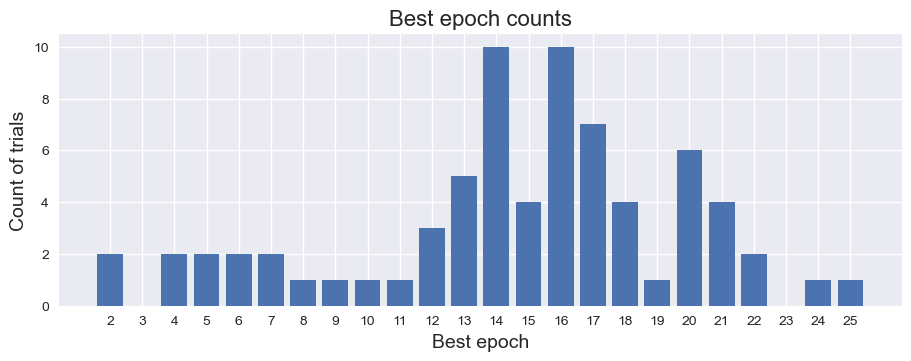

In [79]:
from matplotlib.ticker import MaxNLocator

best_epochs = [
    t.user_attrs["best_epoch"]
    for t in study.trials
    if t.state == optuna.trial.TrialState.COMPLETE and "best_epoch" in t.user_attrs
]

s = pd.Series(pd.to_numeric(best_epochs, errors="coerce")).dropna().astype(int)
if not s.any():
    logging.info("No best_epoch found.")
else:
    # count each integer and include missing integers with count=0
    lo, hi = int(s.min()), int(s.max())
    counts = s.value_counts().sort_index()
    counts = counts.reindex(range(lo, hi + 1), fill_value=0)

    # plot
    fig, ax = plt.subplots(figsize=(9, 3.5), constrained_layout=True)
    ax.bar(counts.index, counts.values, width=0.8)
    ax.set_xlabel("Best epoch")
    ax.set_ylabel("Count of trials")
    ax.set_title(f"Best epoch counts")
    ax.set_xticks(counts.index)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # integer ticks only

    # log best
    logging.info(f"Best epoch by median: {s.median() :.0f}")

    plt.show()


#### View results marginalized on single hyperparameters

In [80]:
from heat_forecast.utils.optuna import (
    plot_marginals_1d, plot_param_importances, display_marginals_1d, marginal_1d
)
import optuna.importance as imp

View fANOVA importances:

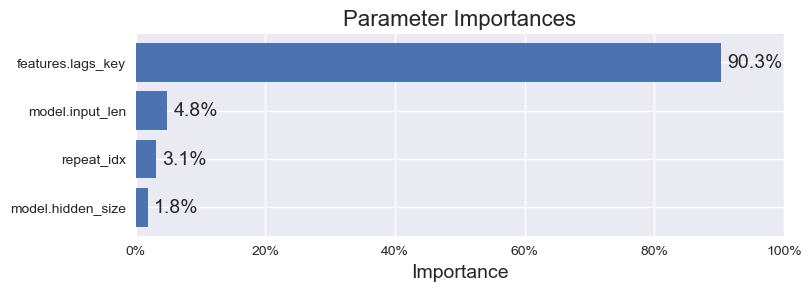

In [81]:
# get importances
imps = imp.get_param_importances(study)
imps = pd.Series(imps, dtype=float).sort_values(ascending=False)

# plot
if imps.any():
    fig, ax = plot_param_importances(imps)

Compute and plot 1d marginals:

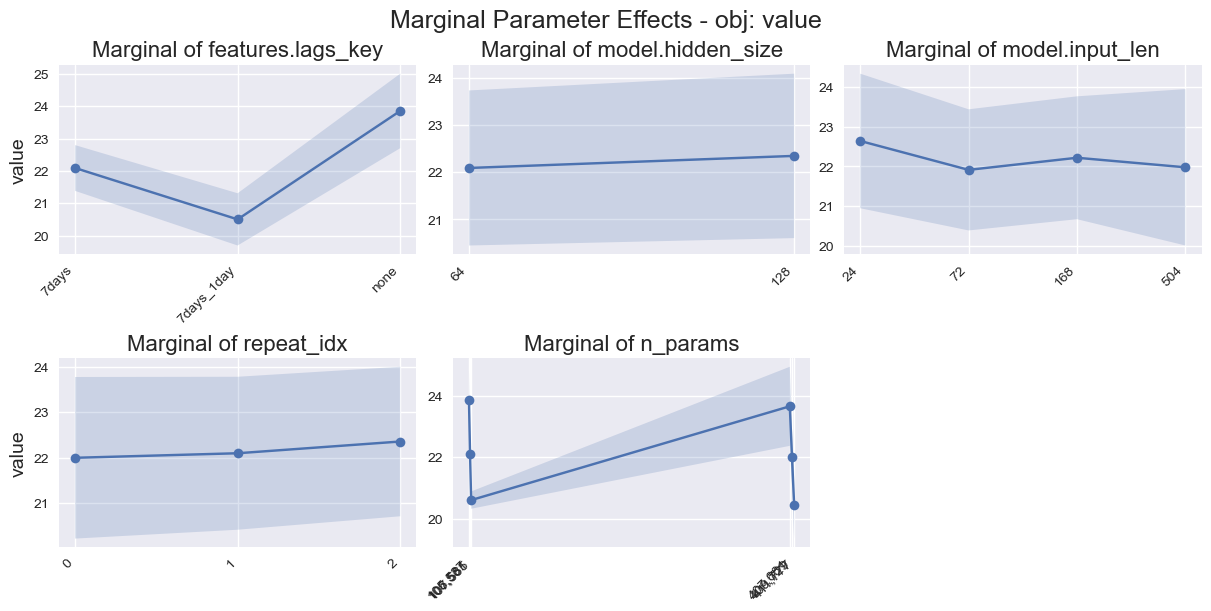

In [83]:
plot_marginals_1d(
    df,
    bins_numeric=10,
    non_params_to_allow=["user_attrs_n_params"],
    #objective="user_attrs_avg_near_best"
)

Plot only a subset of marginals (e.g. most important):

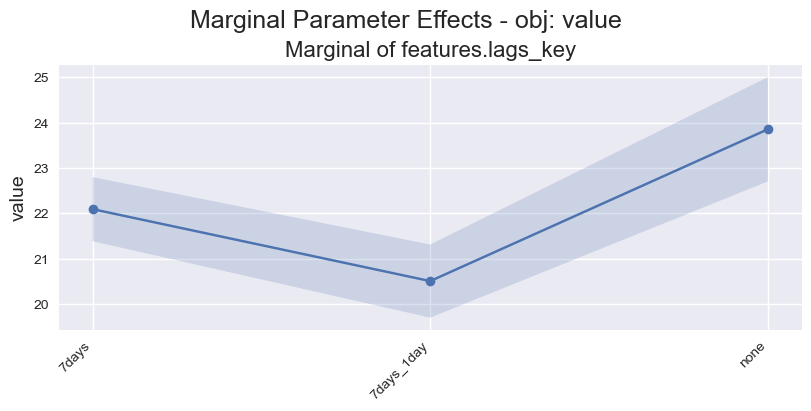

In [84]:
most_imp_params = imps[:1].index.tolist()

plot_marginals_1d(
    df,
    params=most_imp_params,
    bins_numeric=12,
    #non_params_to_allow=["user_attrs_n_params"]
)

Detailed summaries for each parameter:

In [60]:
top_k = 10          # Will show the fraction of trials for each parameter choice that belongs to the top_k trials
top_frac = 0.20     # Will show the fraction of trials for each parameter choice that belongs to the top_frac trials
params = None

tbls_sty = display_marginals_1d(
    df,
    #params=[],
    non_params_to_allow=["user_attrs_n_params"],
    objective="user_attrs_avg_near_best",
    top_k=top_k,
    top_frac=top_frac,
    bins_numeric=7,
)

10-03 19:27:32 | INFO | heat_forecast.utils.optuna | Displaying 1D marginals for objective: 'user_attrs_avg_near_best'.
10-03 19:27:32 | INFO | heat_forecast.utils.optuna |  === model.dropout === 


Level,Count,Mean Value,Median Value,P25,P75,Std,Top-K share,Top-Frac share
"(-7.34e-04, 6.35e-03]",24,25.033131,25.115447,24.657373,25.418057,0.548467,0.166667,0.416667
"(6.35e-03, 0.020]",23,25.291139,25.199024,25.026951,25.553859,0.652309,0.086957,0.130435
"(0.020, 0.056]",23,25.235392,24.980216,24.817234,25.559646,0.622322,0.043478,0.304348
"(0.056, 0.090]",23,25.387970,25.328721,25.074152,25.651351,0.600446,0.086957,0.173913
"(0.090, 0.128]",23,25.426415,25.312531,25.015542,25.686354,0.613578,0.000000,0.173913
"(0.128, 0.198]",23,25.430011,25.338955,25.093939,25.834474,0.584423,0.043478,0.130435
"(0.198, 0.300]",24,25.974305,25.879606,25.529252,26.041081,1.085433,0.000000,0.083333


10-03 19:27:32 | INFO | heat_forecast.utils.optuna |  === model.hidden_size === 


Level,Count,Mean Value,Median Value,P25,P75,Std,Top-K share,Top-Frac share
32,14,25.790298,25.721094,25.455691,26.012920,0.519464,0.000000,0.000000
48,30,25.277480,25.250792,24.647754,25.670800,0.667562,0.066667,0.266667
64,45,25.181319,25.103349,24.905161,25.448016,0.582391,0.088889,0.244444
80,25,25.118768,25.123844,24.752119,25.522760,0.528113,0.120000,0.400000
96,25,25.727619,25.477177,25.335273,25.966365,1.125379,0.040000,0.120000
112,11,25.804286,25.727557,25.266715,26.180930,0.640362,0.000000,0.000000
128,13,25.565774,25.555866,25.183615,25.899285,0.552799,0.000000,0.076923


10-03 19:27:32 | INFO | heat_forecast.utils.optuna |  === model.num_layers === 


Level,Count,Mean Value,Median Value,P25,P75,Std,Top-K share,Top-Frac share
1,88,25.337080,25.189587,24.846467,25.701706,0.831386,0.079545,0.272727
2,75,25.469957,25.430559,25.079955,25.719256,0.627559,0.040000,0.120000


10-03 19:27:32 | INFO | heat_forecast.utils.optuna |  === train.drop_epoch === 


Level,Count,Mean Value,Median Value,P25,P75,Std,Top-K share,Top-Frac share
4,72,25.251143,25.203697,24.972353,25.600638,0.518060,0.083333,0.236111
6,52,25.341860,25.310997,24.976325,25.615907,0.621583,0.057692,0.173077
8,39,25.744892,25.601083,25.126490,26.307167,1.077194,0.025641,0.179487


10-03 19:27:32 | INFO | heat_forecast.utils.optuna |  === train.learning_rate === 


Level,Count,Mean Value,Median Value,P25,P75,Std,Top-K share,Top-Frac share
"(-4.99e-04, 5.33e-04]",24,25.262225,25.459762,24.884793,25.591754,0.422610,0.041667,0.250000
"(5.33e-04, 5.77e-04]",23,25.276493,25.268554,25.046927,25.485388,0.598655,0.086957,0.130435
"(5.77e-04, 6.94e-04]",23,25.001270,25.123844,24.795526,25.219566,0.449066,0.130435,0.391304
"(6.94e-04, 8.37e-04]",23,25.254571,25.163242,24.973393,25.577277,0.573200,0.086957,0.217391
"(8.37e-04, 1.24e-03]",23,25.701301,25.477177,25.064616,25.934032,1.166157,0.000000,0.130435
"(1.24e-03, 1.72e-03]",23,25.472017,25.669678,24.777940,26.004224,0.712234,0.043478,0.260870
"(1.72e-03, 1.99e-03]",24,25.807768,25.819444,25.200124,26.181515,0.714764,0.041667,0.041667


10-03 19:27:32 | INFO | heat_forecast.utils.optuna |  === user_attrs_n_params === 


Level,Count,Mean Value,Median Value,P25,P75,Std,Top-K share,Top-Frac share
"(12192.999, 25098.143]",24,25.327039,25.415234,24.564955,25.717553,0.699731,0.083333,0.291667
"(25098.143, 40769.000]",37,25.274380,25.176813,24.967279,25.589843,0.601519,0.081081,0.216216
"(40769.000, 61201.000]",13,24.969461,24.801855,24.678693,25.162667,0.460122,0.153846,0.538462
"(61201.000, 85729.000]",25,25.748259,25.430559,25.131088,26.043924,1.143510,0.000000,0.080000
"(85729.000, 114353.000]",18,25.278784,25.277637,24.973936,25.581442,0.590425,0.055556,0.166667
"(114353.000, 234721.000]",31,25.395848,25.481859,25.075489,25.666655,0.552316,0.064516,0.193548
"(234721.000, 411265.000]",15,25.753997,25.580814,25.194324,26.204331,0.656651,0.000000,0.000000


#### Study interactions between hyperparameters

In [85]:
from optuna.visualization import plot_parallel_coordinate
from heat_forecast.utils.optuna import marginal_2d

Show parallel coordinate plot (mostly userful when using continuous params):

In [62]:
top_frac = 0.3   # color only top_frac% of trials
params = None    # choose params to plot
# params = imps[:6].index.tolist()  # alternative: pick only the most important

fig = plot_parallel_coordinate(study, params=params)

vals = df["value"].dropna().to_list()
th = np.quantile(vals, top_frac)
fig = optuna.visualization.plot_parallel_coordinate(study, params=params)
fig.data[0].dimensions[0].constraintrange = [min(vals), th]
fig.update_coloraxes(cmin=min(vals), cmax=max(vals))  

fig.show()

Below we can visualize pairwise relationships between parameters or user-defined attributes by creating 2D marginal plots. The function let you choose which variables to compare, which objective to evaluate (default: `"value"`, i.e., best validation MAE), which summary statistic to display, and the binning strategy used.

In [89]:
from heat_forecast.utils.optuna import plot_marginals_2d

fig, pivots = plot_marginals_2d(
    df,
    #objective="user_attrs_avg_near_best",
    #params=["model.hidden_size", "train.learning_rate"], #imps.index[:3].tolist(),
    #as_first="model.num_layers", #imps.index[0],
    statistic="median",
    binning="quantile",
    show_text=True,
    bins_a=4,
    bins_b=4,
    #non_params_to_allow=["user_attrs_n_params"]
)
fig.show()



Display the tables plotted above, or choose a different statistic.

In [66]:
statistic = "std"
n_max = 20 # max number of tables to display

for key, pivs in list(pivots.items())[:n_max]:
    logging.info(f"2D marginal for {key}, statistic = '{statistic}':")
    piv = pivs.get(statistic)
    display(piv if piv is not None else f"(Not found)")

10-03 19:34:38 | INFO | root | 2D marginal for ('params_model.hidden_size', 'params_train.learning_rate'), statistic = 'std':


train.learning_rate,"(-4.99e-04, 5.71e-04]","(5.71e-04, 7.78e-04]","(7.78e-04, 1.32e-03]","(1.32e-03, 1.99e-03]"
model.hidden_size,,,,
"(31.999, 48]",0.532,0.605,0.538,0.866
"(48.000, 64]",0.559,0.414,0.539,0.662
"(64.000, 96]",0.572,0.516,1.993,0.618
"(96.000, 128]",0.390,0.729,0.643,0.696


10-03 19:34:38 | INFO | root | 2D marginal for ('params_model.hidden_size', 'user_attrs_n_params'), statistic = 'std':


user_attrs_n_params,"(12192.999, 40,769]","(40769.000, 62,065]","(62065.000, 147,073]","(147073.000, 411,265]"
model.hidden_size,,,,
"(31.999, 48]",0.696,0.652,NaN,NaN
"(48.000, 64]",0.575,NaN,0.634,NaN
"(64.000, 96]",NaN,0.479,1.526,0.562
"(96.000, 128]",NaN,NaN,0.513,0.680


10-03 19:34:38 | INFO | root | 2D marginal for ('params_train.learning_rate', 'user_attrs_n_params'), statistic = 'std':


user_attrs_n_params,"(12192.999, 40,769]","(40769.000, 62,065]","(62065.000, 147,073]","(147073.000, 411,265]"
train.learning_rate,,,,
"(-4.99e-04, 5.71e-04]",0.484,0.541,0.615,0.571
"(5.71e-04, 7.78e-04]",0.444,0.533,0.488,0.560
"(7.78e-04, 1.32e-03]",0.497,0.373,1.557,0.502
"(1.32e-03, 1.99e-03]",0.796,0.834,0.617,0.615


## Results of Optuna tuning

As discussed earlier, the pipeline involves many parameters, making it impractical to tune all of them extensively at the same time. Instead, our approach focuses on per-series tuning of hyperparameters that are most relevant to the **model** (see *ModelConfig*) and **training** (see *TrainConfig*).

The tuning procedure is organized in two main stages:

1. **Preliminary study (broad exploration across series)**

   The goal of this first phase is:
   * Identify reasonable starting values for feature-related hyperparameters (*FeatureConfig*).
   * Narrow down the set of promising feature configurations to as few as possible, since the main effort during model tuning will target other hyperparameters.
   * Define reasonable hyperparameter search spaces for the subsequent tuning phase.

2. **Model tuning (per-series optimization)**

   This second phase consists in:
   * For each `unique_id` and both forecast horizons (**24 hours** and **7 days**), develop a tailored model.
   * Fix certain hyperparameters based on insights from the preliminary study (either because they consistently outperformed alternatives or because they proved largely inconsequential).
   * Focus optimization on the remaining hyperparameters, ensuring that search efforts target those with the greatest impact on performance.

### **Preliminary Study**

The preliminary study was conducted in multiple steps. Each step could include one or more Optuna studies, all sharing the same objective function: the **best validation MAE** on the cold semester 2023/2024 after a single model fit.

Concretely, for each trial:

* The model with the given configuration is trained on all data up to (but excluding) November 2023, using MAE as the loss.
* At the end of each epoch, validation MAE on the period 2023-11-01 to 2024-04-01 (included) is recorded.
* Training stops when the early stopper is triggered, or when a maximum number of epochs is reached.
* The objective function returns the **minimum validation MAE** achieved during training.

We report the best validation MAE (minimum across epochs) rather than the final value, since once a promising configuration is identified, we refit with multiple seeds and select the training duration as the median of the best epochs across repeats, ensuring a stable and robust choice of epochs.

Below, I summarize the findings for each step. For detailed results, refer to the beginning of this section and select the relevant `unique_id` (e.g., F1) and study name.

#### **Step 0 - Manual trials**

The process began with a few quick, **manual experiments** on series **F1**. Here, model, training, and data hyperparameters were fixed to simple defaults (e.g., 64 hidden units, input length = 168, 1 LSTM layer), with `exog_vars=(temperature,)` and default time-based exogenous features.

These hand-run trials suggested the following:

* `norm.mode=global` clearly outperformed both alternatives `per_sample` and `None`.
* Activating `feature.hour_averages` or `feature.use_cold_season` (i.e., setting them to anything other than `None`/`False`) either degraded performance or had negligible effect.
* `use_differences=False` consistently performed better than `use_differences=True`.
* Including both 24h and 168h lags improved performance.

From these insights, we established new **default values** for data features and normalization, which are now encoded in the configuration classes. These defaults were used as the starting point for subsequent steps.

#### **Step 1 - First effort in model and training parameters tuning**

The first Optuna study, `preliminary_study_v1`, was conducted on series **F1**. Its goal was to explore a broad set of modeling and training parameters, while keeping features and normalization fixed to the defaults determined in Step 0.

**Search space.** We tuned the following parameters:

* `model.head` (categorical): {`linear`, `mlp`}
* `model.hidden_size` (categorical): {32, 64, 128}
* `model.num_layers` (categorical): {1, 2}
* `model.dropout` (categorical): {0.0, 0.15, 0.3}
* `model.input_len` (categorical): {72, 168}
* `data.batch_size` (categorical): {64, 128}
* `train.learning_rate` (float, log scale): [0.0001, 0.005]

Fixed: `norm.mode=global`, `train.n_epochs=35` (with early stopping).
Constraint: skip (`hidden_size=128`, `num_layers=2`, `input_len=168`).

**Sampler behavior.** 
We used Optuna’s default TPE sampler (`n_startup_trials=10`, `n_ei_candidates=24`). Because the search space was predominantly categorical (\~86%), the sampler quickly focused on early “winning” parameter values instead of exploring evenly. This meant that certain configurations were heavily oversampled, while others were tested only a handful of times. As a result, we obtained good evidence on some parameters, but weaker coverage for others.

 **Observations and commentary.**

* **Input length (`input_len`).**
  The shorter input window (`72`) was overwhelmingly favored by the sampler (\~88% of trials, 181/206) and achieved the lowest median MAE (20.95 vs 21.20 for `168`). Even when conditioning on other parameters, `72` consistently came out ahead. However, the imbalance in sampling weakens our confidence in this result: `168` was underexplored, leaving open the possibility that it could perform better in underrepresented combinations.
  Mechanistically, the result makes sense. Because lagged target values at 24h and 168h are already included as features, much of the seasonal signal is captured without requiring a full 168-step input sequence. This allows the shorter window to be simpler, faster, and equally (or even more) effective. The low fANOVA importance (<3%) further supports that the difference is subtle once lagged features are present.

* **Dropout (`dropout`).**
  Zero dropout (`0.0`) dominated the trials (\~86%) and also delivered the best performance (median MAE 20.92). Increasing dropout led to a clear and consistent degradation (21.14 for 0.15, 21.82 for 0.3), confirmed across median, mean, and interquartile ranges. This suggests that the LSTM models, being relatively small (hidden sizes 32–128), already operate near the limit of their representational capacity, so removing units during training pushes them toward underfitting.
  Interestingly, this result coexists with a preference for smaller batch sizes (see below). The two are not contradictory: dropout reduces *model capacity*, while small batch size introduces *optimization noise*. In this setup, keeping full model capacity while injecting noise through smaller batches appears to be a better balance than handicapping the model with dropout.

* **Number of layers (`num_layers`).**
  Two LSTM layers outperformed one (median MAE 20.94 vs 21.12) and, more importantly, produced more stable results with lower variance. The robustness of two layers is evident in the interaction with hidden size: when hidden size = 32, two layers substantially outperform one (21.19 vs 21.81), suggesting that the added depth compensates for the limited representational power of small hidden dimensions. With larger hidden sizes, the difference narrows but remains in favor of two layers.

* **Hidden size (`hidden_size`).**
  Among the three values tested, `64` gave the best median performance (20.91), with `128` very close behind. `32` was consistently worse (median 22.08), indicating underfitting. This result is intuitive: `32` is too limited to capture the temporal patterns, while `128` may provide unnecessary capacity relative to the dataset size.

* **Head (`model.head`).**
  The choice between `linear` and `mlp` heads showed no consistent effect on performance: both appeared in top-performing trials, and fANOVA assigned this parameter the lowest importance. This suggests that most of the predictive power lies in the LSTM body, not the head. Moreover, the increase in model complexity when switching to an MLP head is minimal (often less than 1% additional parameters).

* **Batch size (`batch_size`).**
  A batch size of `64` slightly outperformed `128` in median MAE (20.93 vs 21.14) and was far more stable (variance 0.77 vs 1.69). The consistency of `64` across interactions reinforces this preference. Smaller batches also introduce more stochasticity in the gradients, which likely acts as an implicit regularizer. This complements the finding on dropout: the model benefits from noisy optimization (batch size effect) but not from reduced representational capacity (dropout).

* **Learning rate (`train.learning_rate`).** The performance curve was clear: values above \~1.5e-3 degraded results, while the best region was between \~6e-4 and 9e-4. Smaller learning rates also remained competitive.

**Reliability.** We evaluated 200 trials across 132 feasible categorical combinations (some lightly sampled). Despite TPE's exploitation, the best-by-median values align with the most-sampled categories, which supports the conclusions.

#### **Step 2 - Exogenous Variables**

This step tested whether adding climate-related exogenous variables (humidity, wind speed, and air pressure) alongside temperature could improve predictive accuracy. Two configurations were compared: **temperature-only (T)** and **temperature + humidity/wind/pressure (THPW)**. Dew point was excluded due to strong collinearity with temperature, making it unlikely to provide additional predictive value.

We ran one Optuna study for each target series (`unique_id`), with four repeats under different seeds for each configuration (T or THPW). All other hyperparameters were fixed to one of the best-performing settings from Step 1 (see referenced studies). Model complexity was not increased when moving from T to THPW, since the parameter growth was modest (\~2% on \~100k total parameters) and therefore unlikely to affect model capacity or regularization.

**Results (by series)**

* **F1** (`preliminary_study_v2_F1`).
  T consistently outperformed THPW in all but one repeat. The single exception was due to a very early trigger of the early stopper, which truncated training and compromised the result. In every trial that lasted a reasonable number of epochs, T achieved lower error. This indicates that the additional variables provide no benefit and, if anything, slightly degrade performance.

* **F2** (`preliminary_study_v2_F2`).
  Results for T and THPW were virtually indistinguishable, with differences smaller than the variability across seeds. Variance across repeats was higher than variance across configurations, showing that randomness in training mattered more than the choice of exogenous inputs. Early stopping typically occurred around 10–15 epochs, while validation loss was still noisy. This instability can be attributed to 
  * small batch size, which increases gradient noise, and 
  * the decay of teacher forcing, which can destabilize validation as the model transitions to fully autoregressive prediction. 
  
  This combination risks premature early stopping. A safer protocol would be to allow a minimum of 10–15 epochs before early stopping is activated, ensuring the model experiences at least a few epochs without teacher forcing. Despite these caveats, the study shows clearly that THPW does not improve over T.

* **F3** (`preliminary_study_v2_F3`).
  No trials stopped prematurely; all lasted at least 13 epochs. Here, there is clear evidence favoring T: median MAE was 29.35 for T versus 31.30 for THPW, a gap of almost 2 points, far larger than the run-to-run variability (std < 0.35). fANOVA attributed \~93% of the variance to the exogenous setting and only \~7% to the repeat index. This strongly confirms that temperature alone is the better choice.

* **F4** (`preliminary_study_v2_F4`).
  In the first study, all trials ended very early (5–10 epochs), likely reflecting the noisy and lower-signal nature of this series. Validation loss converged quickly to near-minimum values, triggering the early stopper prematurely. This made it difficult to separate T and THPW. To address this, we ran a second study (`preliminary_study_v2_F4_second`) enforcing a minimum of 16 epochs before early stopping could trigger. The second study confirmed that THPW offered no advantages: validation loss remained flat or worsened slightly in both configurations over the additional epochs. This reinforces the view that, for this noisier series, the extra variables do not add meaningful signal.

* **F5** (`preliminary_study_v2_F5`).
  Again, T outperformed THPW. The gap in median MAEs was \~1.6 points (37.57 vs. 39.18), well above run-to-run variability. fANOVA results aligned with this finding. Early stopping often occurred relatively early (median \~11 epochs), which is consistent with the noisier nature of this series, where overfitting emerges faster. Nonetheless, the advantage for T is clear and robust.

**Early stopping considerations.**
The issue of noisy validation loss and premature stopping is most visible in F2 and F4. Step 1, however, was conducted entirely on F1, which in Step 2 showed little evidence of early stopping problems. This makes us confident that the results of Step 1 remain reliable, since the series used there (F1) is less prone to premature early stopping compared to noisier ones like F2 or F4. This interpretation is further supported by the inspection of Step 1 runs, where the vast majority of trials (~88%) lasted beyond 15 epochs without signs of instability.

**Conclusions.**
Across all five series, **temperature alone was either equally effective or superior**. Adding humidity, wind speed, and air pressure never improved accuracy, and in F3 and F5 significantly worsened it. Given the parameter increase (\~2%) and the complete lack of consistent benefit, **temperature-only should be adopted as the default exogenous input** for subsequent studies.

#### **Step 3 - Input Length vs. Lag Features**

Step 3 focused on comparing **short vs. long input windows (`input_len`)**, both when including lagged values of the target/exogenous variables and when excluding them.

In principle, the LSTM’s hidden and cell states should retain contextual information across the full lookback window. However, this information must be compressed into the final encoder state before being passed to the decoder. This bottleneck can limit the model's ability to recall specific time points. Since we have strong prior evidence that the 24h and 168h lags are highly predictive, it is reasonable to expect that making such lags directly available as input features helps the model recognize and exploit them. This logic is similar to that of attention mechanisms in sequence models: attention explicitly highlights important past timestamps to overcome the limitations of compressing the entire history into a single state. Here, we test whether directly providing lagged features is more effective than relying on the LSTM to infer them from the raw input window.

Because each study required several hours to complete, we ran this experiment only on two representative series:

* **F1**: one of the most visually regular series, where results are likely to be cleaner.
* **F3**: the less noisy of the two strongly weekly-seasonal series (F3 and F5), providing contrast to F1.

For these studies (and subsequent ones), we set `features.include_exog_lags=True`. This decision was motivated by preliminary results on F1 (`preliminary_study_v3_F1_oninclude`), which showed improved performance when including lagged exogenous variables. Intuitively, this also makes sense: allowing the model to access lagged values of both target and exogenous variables provides a richer context and enables learning relationships that persist across time.

**Search space.** We repeated three seeded trials for each configuration of the following categorical parameters:

* `model.input_len`: {24, 72, 168, 504}
* `features.endog_hour_lags`: {(), (168,), (168, 24)}
* `model.hidden_size`: {64, 128}

Fixed parameters: `num_layers=2`, `head='linear'`, `dropout=0.1`, `lr=7e-4`, `batch_size=64`, `norm.mode='global'`, `n_epochs=25` (with early stopping).

**Results (by series).** In the following, we denote **7D1D**, **7D**, **N** the (partial) configurations with, respectively, `endog_hour_lags=(168, 24)`, `(168,)` and `()`.

* **F1** (`preliminary_study_v3_F1`).
  The results show a clear preference for the 7D1D configuration. Median MAEs steadily worsen as lags are removed: 20.74 (7D1D), 22.30 (7D), 24.25 (N). Standard deviations remain low (<0.8) when at least one lag is included, suggesting the improvement is robust. fANOVA confirms this effect, attributing \~90% of importance to the lag parameter. Interestingly, this preference holds across all input lengths: even with the longest windows (three weeks), 7D1D strongly outperforms the alternatives. This supports the bottleneck explanation: the model benefits most when the key lagged signals are explicitly provided rather than left for the LSTM to recover indirectly.

* **F3** (`preliminary_study_v3_F3`).
  The findings are even more pronounced. Here, the lag parameter dominates almost entirely, with \~96% fANOVA importance. Including the 7D1D lags leads to markedly better performance compared to other settings, leaving little ambiguity in the result.

**Additional comment on input length.** When the lag parameter is fixed, differences across input window lengths are minimal. For both F1 and F3, extending the lookback horizon does not lead to meaningful accuracy gains. The main effect of increasing `input_len` is a slight rise in variability: in F1, the standard deviation of the objective grows from 1.53 at `input_len=72` to 1.97 at `input_len=504`, while in F3 it increases from 1.35 to 1.69 over the same range. This pattern suggests that longer windows add noise without clear benefits, reinforcing `input_len=72` as a stable and effective default.

#### **Step 4 - Effect of the Autoregressive Variable**

In this step, we tested our best-performing configuration so far (largely calibrated on F1) with and without the **autoregressive (AR) variable** in the decoder. This variable corresponds to feeding the model’s own prediction from the previous time step back into the decoder as input at the next step. The main motivation for removing it is **computational efficiency**.

**Why consider removing the autoregressive variable?**

1. **Computational overhead per horizon.**
   With the AR variable, the decoder must be called explicitly **H times**, where *H* is the forecast horizon, because each prediction depends on the previous one. This sequential dependency prevents batching the decoder inputs, making both forward and backward passes substantially slower. In practice, with a configuration like the one used in this study, epochs with **0 teacher forcing** (full AR decoding) ran up to **5× slower** than epochs with full teacher forcing (a single decoder call per pass).

2. **Scalability with forecast horizon.**
   This overhead grows rapidly as the horizon increases. For example, extending the output window to a week, a single training epoch with AR decoding took nearly **30 minutes** on GPU, compared to only \~10 seconds without AR feedback. This scaling makes AR decoding impractical for longer horizons.

3. **Extension to longer horizons.**
   The non-AR variant provides a straightforward path to weekly forecasts. Instead of predicting hour by hour, the model can predict in **24-hour blocks** and then reuse those block predictions as lagged inputs for subsequent decoder calls. Exogenous lags remain usable, since we assume reliable forecasts for exogenous variables are available up to seven days ahead. This block-autoregressive strategy allows reusing most of the current setup, with only teacher forcing scheduling requiring adjustment.

4. **Simpler training dynamics.**
   For the 24-hour forecast case, removing the AR variable also simplifies training. There is no need to design a teacher forcing schedule, and the model is trained directly in the evaluation setting (no teacher forcing) from the start. This can reduce the number of epochs needed to converge, further decreasing training time.

**Trade-off.**
The main drawback of removing the AR variable is a potential loss in accuracy. AR decoding enforces temporal consistency by conditioning each prediction on the model's own previous outputs; without it, forecasts may become less coherent, especially at longer horizons. In our setting, however, this effect could be mitigated by the inclusion of strong lag features of the target (24h and 168h) and informative exogenous variables. These features anchor predictions to actual past observations and external drivers, reducing the model’s reliance on its own autoregressive feedback. The extent of this mitigation is dataset-dependent, but for the horizons and variables considered here, the central question is whether any residual accuracy loss is small enough to justify the substantial computational gains.

**Search space.**
We ran four seeded trials for each configuration:

* `use_ar_prev=True` (autoregressive decoder input included)
* `use_ar_prev=False` (autoregressive decoder input removed)

Fixed parameters: `input_len=72`, `hidden_size=64`, `num_layers=2`, `head='linear'`, `dropout=0.1`, `lr=7e-4`, `batch_size=64`, `norm.mode='global'`, `n_epochs=25` (with early stopping). All other parameters were kept at their defaults.

**Results (by series).**

* **F1 & F2.**
  Accuracy differences between AR and no-AR are negligible: validation MAEs differed by <0.1 (within one standard deviation), and fANOVA attributed \~75% of variance to repeat index versus \~25% to AR. Runtime, by contrast, was nearly **4× faster** without AR (averaging \~1′30″ per trial vs. \~5–6′ with AR). Validation loss curves for no-AR were smoother and reached stability earlier, with best epochs remaining close (median 14 vs. 17 on F1; 13 vs. 14 on F2).

* **F3–F5.**
  No-AR again showed **no loss in accuracy**, while consistently converging earlier and with smoother curves. AR models, slowed by teacher forcing, required more epochs to stabilize and sometimes converged later to the same level reached by no-AR after only a few epochs. Runtimes were \~1′20″ per trial with no-AR vs. \~3–4′ with AR, again a **3–4× speed-up**. These values are somewhat inflated because we forced at least 16 epochs; in noisier series like these, no-AR typically converges much earlier, so the true speed-up is likely closer to 4×.

**Conclusions.**
Across all five series, removing the AR variable had **no meaningful impact on accuracy** but consistently delivered **3–4× faster training** with smoother and earlier convergence. These findings strongly support adopting the non-AR configuration as the default going forward.

### **Final Tuning Phase**

The final tuning phase focuses exclusively on model and training parameters, while fixing other settings based on insights from the preliminary studies. We conducted this tuning on the **7-day ahead forecasting model**, rather than the 24-hour model, for the following reasons:

1. **Training complexity**:
   The 7-day model uses a *partially autoregressive decoder*, where predictions from each day are fed into the decoder to produce predictions for the next day. This requires scheduling of teacher forcing, which is absent in the 24-hour model. By tuning the 7-day model first, we ensure that the most complex training setup is properly optimized. From this tuned model, we can then derive a robust 24-hour version by simply replacing the autoregressive predictions in the decoder with a 24-hour lag of the target. The resulting model may be slightly overpowered, since it no longer needs to learn how to correct its own predictions, but it is expected to be well tuned. The only additional step will be to adjust the number of training epochs, as the 24-hour model should converge faster without teacher forcing. The reverse path (going from a tuned 24-hour model to a 7-day model) would be less straightforward, since we would lack guidance on how to schedule teacher forcing.

2. **Consistency with SARIMAX**:
   We followed a similar strategy for SARIMAX, tuning only the 7-day ahead model and then reusing those hyperparameters for the 24-hour task. Since the 7-day horizon is more challenging, this approach was judged more effective than the opposite. Adopting the same methodology here also ensures a fairer comparison between SARIMAX and LSTM results.

**Search space.** We tuned the following parameters:

* `model.num_layers` (categorical): {1, 2}
* `model.hidden_size` (int): {32, 48, 64, 80, 96, 112, 128}
* `model.dropout` (float): [0.0, 0.3]
* `train.learning_rate` (float, log scale): [0.0005, 0.002]
* `train.drop_epoch` (int): {4, 6, 8}

**Fixed:** `input_len = 72`, `head = linear`, `batch_size = 64`, `include_exog_lags = True`, `n_epochs = 25`, `lr_drop = True` (`factor = 0.3`, `epoch = train.drop_epoch`), `norm.mode = global`. (See sampler documentation for additional details.)

**Rationale for fixed choices.**

* **Input length**: set to 72, as prior studies showed no benefit from longer or shorter horizons; this is also interpretable given the reliance on lagged target and exogenous values.
* **Exogenous variables**: only temperature retained, since additional variables did not improve results.
* **Batch size**: fixed to 64, consistent with both preliminary studies and early final tuning runs (`final_study_v1_F1`, `final_study_v1_F2`).
* **Weight decay**: tested but had negligible effect (fANOVA importance < 1%), so fixed to 0 to keep the search focused.

**Optimization strategy.** We used the TPE sampler with a non-default configuration to reduce over-exploitation and encourage broader exploration of the search space. A percentile pruner (60% percentile, patience = 3) was applied with mild pruning. Early stopping was made slightly more stringent by requiring a minimum relative improvement of 0.5% (`es_rel_delta = 0.5%`) to reset the stopping counter.

Final configurations:

In [ ]:
# TO DO

## Test

Code for final testing with the tuned models:

In [ ]:
config_F1 = LSTMRunConfig(
    model=ModelConfig(
        input_len=72, 
        output_len=24, 
        hidden_size=64, 
        num_layers=2,
        head="linear",
        dropout=0.0
    ),
    data=DataConfig(
        batch_size=32,   
    ),
    features=FeatureConfig(
        exog_vars=("temperature",),       
        endog_hour_lags=(24, 168,),  
        include_exog_lags=True
    ),
    train=TrainConfig(
        learning_rate=5e-4, 
        n_epochs=15, 
        patience=5, 
        tf_mode="linear"
    ),
    norm=NormalizeConfig(mode="global"),
    seed=SEED,
)

# Choose unique_id and filter
unique_id = 'F4'
horizon_type = 'day'
max_n_fits = 1

assert horizon_type in ('day', 'week'), "horizon_type must be 'day' or 'week'"
config = copy.copy(config_F1)
config.model.output_len = 24  if horizon_type == 'day' else 168 # 24h for day, 168h for week

In [ ]:
grid = list(product(['F5'], ['day']))
for id, horizon_type in tqdm(grid, desc="Test", leave=True):

    metadata = {}

    # ------------- Create directory for test results -------------
    timestamp = datetime.now().strftime("%Y%m%dT%H%M%S")
    run_id = f"{id}_{horizon_type}_test_lstm_{timestamp}"
    path = BASE_DIR / "results" / "test" / "lstm" / run_id
    metadata['run_id'] = run_id

    try:
        path.mkdir(parents=True, exist_ok=False)
        logging.info(f"Created directory for test results: {path.relative_to(BASE_DIR)}")


        # ------------- Set params for cv -------------
        out = get_cv_params_for_test(id, horizon_type, max_n_fits=max_n_fits)
        metadata['for_cv'] = {
            'step_size': out['step_size'],
            'test_hours': out['test_hours'],
            'end_test_cv': str(out['end_test_actual']),
            'n_windows': out['n_windows'],
            'input_size': None,
            'refit': out['refit'],
            'n_fits': out['n_fits'],
        }

        # ------------- Run cross-validation with the optimal parameters -------------
        # create pipeline and generate futures
        heat_id_df = heat_df[heat_df['unique_id'] == id]
        aux_id_df = aux_df[aux_df['unique_id'] == id]
        pipe = LSTMPipeline(
            target_df=heat_id_df, 
            config=config, 
            aux_df=aux_id_df, 
        )
        metadata['model_config'] = config.to_dict()
        metadata['device'] = DEVICE.type

        # Run cv
        t0 = pd.Timestamp.now()
        cv_df = pipe.cross_validation(
            test_size=out['test_hours'],  # Test size in hours
            end_test=out['end_test_actual'],  # End of the test period
            step_size=out['step_size'],   # Step size in hours
            refit=out['refit'],  # Do not refit the model on each window
            verbose=True,
        )
        t1 = pd.Timestamp.now()

        avg_elapsed = (t1 - t0).total_seconds() / out['n_fits']
        metadata['avg_elapsed_per_fit'] = avg_elapsed

        cv_df.to_parquet(path / "cv_df.parquet", compression="snappy")

        metadata_path = path / 'metadata.yaml'
        with open(metadata_path, 'w') as f:
            yaml.safe_dump(
                metadata,
                f,
                default_flow_style=False,    # block style
                sort_keys=False              # preserve insertion order
            )

        logging.info(f"✓ Artifacts saved successfully for id={id}, horizon={horizon_type}.")

    except KeyboardInterrupt:
        logging.warning("✗ Interrupted; cleaning up.")
        remove_tree(path, require_within=BASE_DIR)
        logging.info("✓ Removed %s", Path(path).relative_to(BASE_DIR) if BASE_DIR in Path(path).resolve().parents else path)
        raise
    except Exception:
        logging.exception("✗ Error during test for id=%s, horizon=%s; cleaning up.", id, horizon_type)
        remove_tree(path, require_within=BASE_DIR)
        logging.info("✓ Removed %s", Path(path).relative_to(BASE_DIR) if BASE_DIR in Path(path).resolve().parents else path)
        raise

logging.info(f"✓ Test completed.")